# Data
[Curated Stack Overflow pair of intent and code snippet](https://conala-corpus.github.io/)  

In [1]:
import json
import re
import ast
import sys
import nltk
import traceback
import astor
import token as tk
from tokenize import generate_tokens
from io import StringIO
import itertools 
from gensim.models import FastText
from gensim.models import KeyedVectors
from time import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File path
train_path="data/conala-corpus/conala-train.json"
test_path="data/conala-corpus/conala-test.json"

train_clean_output_path="data/conala-corpus/.train.seq2seq"
test_clean_output_path="data/conala-corpus/.test.seq2seq"

unsupervised_wordembedding_file_path="data/conala-corpus/u_embeddings.txt"
supervised_wordembedding_file_path="data/conala-corpus/s_embeddings.txt"

#docembedding_file_path="data/document_embeddings.csv"

In [3]:
QUOTED_STRING_RE = re.compile(r"(?P<quote>[`'\"])(?P<string>.*?)(?P=quote)")


def canonicalize_intent(intent):
    str_matches = QUOTED_STRING_RE.findall(intent)

    slot_map = dict()

    return intent, slot_map


def replace_strings_in_ast(py_ast, string2slot):
    for node in ast.walk(py_ast):
        for k, v in list(vars(node).items()):
            if k in ('lineno', 'col_offset', 'ctx'):
                continue
            # Python 3
            # if isinstance(v, str) or isinstance(v, unicode):
            if isinstance(v, str):
                if v in string2slot:
                    val = string2slot[v]
                    # Python 3
                    # if isinstance(val, unicode):
                    #     try: val = val.encode('ascii')
                    #     except: pass
                    setattr(node, k, val)
                else:
                    # Python 3
                    # if isinstance(v, str):
                    #     str_key = unicode(v)
                    # else:
                    #     str_key = v.encode('utf-8')
                    str_key = v

                    if str_key in string2slot:
                        val = string2slot[str_key]
                        if isinstance(val, str):
                            try: val = val.encode('ascii')
                            except: pass
                        setattr(node, k, val)


def canonicalize_code(code, slot_map):
    string2slot = {x[1]['value']: x[0] for x in list(slot_map.items())}

    py_ast = ast.parse(code)
    replace_strings_in_ast(py_ast, string2slot)
    canonical_code = astor.to_source(py_ast)

    return canonical_code


def decanonicalize_code(code, slot_map):
    try:
        slot2string = {x[0]: x[1]['value'] for x in list(slot_map.items())}
        py_ast = ast.parse(code)
        replace_strings_in_ast(py_ast, slot2string)
        raw_code = astor.to_source(py_ast)
      # for slot_name, slot_info in slot_map.items():
      #     raw_code = raw_code.replace(slot_name, slot_info['value'])

        return raw_code.strip()
    except:
        return code

def detokenize_code(code_tokens):
    newline_pos = [i for i, x in enumerate(code_tokens) if x == '\n']
    newline_pos.append(len(code_tokens))
    start = 0
    lines = []
    for i in newline_pos:
        line = ' '.join(code_tokens[start: i])
        start = i + 1
        lines.append(line)

    code = '\n'.join(lines).strip()

    return code


def encode_tokenized_code(code_tokens):
    tokens = []
    for token in code_tokens:
        if token == '\t':
            tokens.append('_TAB_')
        elif token == '\n':
            tokens.append('_NEWLINE_')


def get_encoded_code_tokens(code):
    code = code.strip()
    #print(code)
    token_stream = generate_tokens(StringIO(code).readline)
    tokens = []
    indent_level = 0
    new_line = False

    for toknum, tokval, (srow, scol), (erow, ecol), _ in token_stream:
        if toknum == tk.NEWLINE:
            tokens.append('#NEWLINE#')
            new_line = True
        elif toknum == tk.INDENT:
            indent_level += 1
            # new_line = False
            # for i in range(indent_level):
            #     tokens.append('#INDENT#')
        elif toknum == tk.STRING:
            tokens.append(tokval.replace(' ', '#SPACE#').replace('\t', '#TAB#').replace('\r\n', '#NEWLINE#').replace('\n', '#NEWLINE#'))
        elif toknum == tk.DEDENT:
            indent_level -= 1
            # for i in range(indent_level):
            #     tokens.append('#INDENT#')
            # new_line = False
        else:
            tokval = tokval.replace('\n', '#NEWLINE#')
            if new_line:
                for i in range(indent_level):
                    tokens.append('#INDENT#')

            new_line = False
            tokens.append(tokval)

    # remove ending None
    if len(tokens[-1]) == 0:
        tokens = tokens[:-1]

    if '\n' in tokval:
        pass

    return tokens


def tokenize(code):
    token_stream = generate_tokens(StringIO(code).readline)
    tokens = []
    for toknum, tokval, (srow, scol), (erow, ecol), _ in token_stream:
        if toknum == tk.ENDMARKER:
            break

        tokens.append(tokval)

    return tokens


def compare_ast(node1, node2):
    # Python 3
    # if not isinstance(node1, str) and not isinstance(node1, unicode):
    if not isinstance(node1, str):
        if type(node1) is not type(node2):
            return False
    if isinstance(node1, ast.AST):
        for k, v in list(vars(node1).items()):
            if k in ('lineno', 'col_offset', 'ctx'):
                continue
            if not compare_ast(v, getattr(node2, k)):
                return False
        return True
    elif isinstance(node1, list):
        return all(itertools.starmap(compare_ast, zip(node1, node2)))
    else:
        return node1 == node2


def encoded_code_tokens_to_code(encoded_tokens, indent=' '):
    decoded_tokens = []
    for i in range(len(encoded_tokens)):
        token = encoded_tokens[i]
        token = token.replace('#TAB#', '\t').replace('#SPACE#', ' ')

        if token == '#INDENT#': decoded_tokens.append(indent)
        elif token == '#NEWLINE#': decoded_tokens.append('\n')
        else:
            token = token.replace('#NEWLINE#', '\n')
            decoded_tokens.append(token)
            decoded_tokens.append(' ')

    code = ''.join(decoded_tokens).strip()

    return code


def find_sub_sequence(sequence, query_seq):
    for i in range(len(sequence)):
        if sequence[i: len(query_seq) + i] == query_seq:
            return i, len(query_seq) + i

    raise IndexError


def replace_sequence(sequence, old_seq, new_seq):
    matched = False
    for i in range(len(sequence)):
        if sequence[i: i + len(old_seq)] == old_seq:
            matched = True
            sequence[i:i + len(old_seq)] = new_seq
    return matched

In [4]:
# read and clean data
def read_clean_dataset(dataset_path, output_path):
    train = json.load(open(dataset_path))

    for i, example in enumerate(train):
        # updating `train` in place
        intent = example['intent']

        rewritten_intent = example['rewritten_intent']

        snippet = example['snippet']
        # print(i)
        # code_tokens = get_encoded_code_tokens(snippet)
        # print(' '.join(code_tokens))

        failed = False
        intent_tokens = []
        if rewritten_intent:
            try:
                canonical_intent, slot_map = canonicalize_intent(rewritten_intent)
                #print(canonical_intent, slot_map)

                snippet = snippet
                canonical_snippet = canonicalize_code(snippet, slot_map)
                #print("canonical_snippet:", canonical_snippet, slot_map)

                intent_tokens = nltk.word_tokenize(canonical_intent)

                decanonical_snippet = decanonicalize_code(canonical_snippet, slot_map)
                #print("decanonical_snippet: ",decanonical_snippet)

                snippet_reconstr = astor.to_source(ast.parse(snippet)).strip()
                #print("snippet_reconstr: ",decanonical_snippet)

                decanonical_snippet_reconstr = astor.to_source(ast.parse(decanonical_snippet)).strip()
                #print("decanonical_snippet_reconstr: ",decanonical_snippet_reconstr)
                encoded_reconstr_code = get_encoded_code_tokens(decanonical_snippet_reconstr)
                decoded_reconstr_code = encoded_code_tokens_to_code(encoded_reconstr_code)

                # syntax error in snippet
                if not compare_ast(ast.parse(decoded_reconstr_code), ast.parse(snippet)):
                    print(i)
                    print('Original Snippet: %s' % snippet_reconstr)
                    print('Tokenized Snippet: %s' % ' '.join(encoded_reconstr_code))
                    print('decoded_reconstr_code: %s' % decoded_reconstr_code)

            except:
                print('*' * 20, file=sys.stderr)
                print(i, file=sys.stderr)
                print(intent, file=sys.stderr)
                print(snippet, file=sys.stderr)
                traceback.print_exc()

                failed = True
            finally:
                example['slot_map'] = slot_map

        if rewritten_intent is None:
            encoded_reconstr_code = get_encoded_code_tokens(snippet.strip())
        else:
            encoded_reconstr_code = get_encoded_code_tokens(canonical_snippet.strip())

        if not intent_tokens:
            intent_tokens = nltk.word_tokenize(intent)

        example['intent_tokens'] = intent_tokens
        example['snippet_tokens'] = encoded_reconstr_code

    json.dump(train, open(output_path, 'w'), indent=2)
    
read_clean_dataset(train_path, train_clean_output_path)
read_clean_dataset(test_path, test_clean_output_path)

# Methods

## StarSpace Word Embedding on both *Intent* and *Snippet*

### Preparing Training Data

In [5]:
train_clean = json.load(open(train_clean_output_path))

In [6]:
star_keywrods = []
for i, example in enumerate(train_clean):
    star_keywrods.append((example["intent_tokens"],example["snippet_tokens"]))

In [7]:
print(len(star_keywrods))

2379


In [ ]:
# for supervise training
with open('supervised_train.tsv', 'w') as f:
    for data in star_keywrods:
        for word in data[0]:
            f.write("%s " % word)
        f.write("\t")
        for word in data[1]:
            f.write("%s " % word)
        f.write("\n")
    f.close()

In [ ]:
# for unsupervise training
with open('unsupervised_train.tsv', 'w') as f:
    for data in star_keywrods:
        for word in data[0]:
            f.write("%s " % word)
        for word in data[1]:
            f.write("%s " % word)
        f.write("\n")
    f.close()

### Parameter and Train

In [ ]:
# for unsupervised training

./starspace train -trainFile "../erica/256/unsupervised_train.tsv" \ 
-model "../erica/256/embedding5" \
-trainMode 5 \
-adagrad true \
-ngrams 1 \
-epoch 10 \
-dim 100 \
-minCount 2 \
-verbose true \
-similarity "cosine" \
-negSearchLimit 10 \
-fileFormat labelDoc \
-lr 0.05 

In [ ]:
# for supervised training

./starspace train 
-trainFile "train.tsv" 
-model "../erica/256/embedding2"  
-trainMode 3 
-adagrad true 
-ngrams 1 
-epoch 10 
-dim 100 
-similarity "cosine" 
-minCount 2 
-negSearchLimit 10  
-verbose true 
-fileFormat labelDoc 
-lr 0.001


# Evaluation

#### 1. Precision 
The Precision measures the percentage of correct result in the top 10 returned results for each query. 
In our evaluations it is calculated as follows:

$Precision = \frac{1}{|Q|}\sum_{q=1}^{|Q|}(correct = 1, else = 0)$

The higher the metric values, the better the code search performance. 

#### 2. Mean Reciprocal Rank
The Mean Reciprocal Rank (MRR) is the average of the reciprocal ranks of results of a set of queries Q. 
The reciprocal rank of a query is the inverse of the rank of the first hit result. 

MRR is calculated as follows: 

$MRR = \frac{1}{|Q|}\sum_{q=1}^{|Q|}\frac{1}{FRankq}$


The higher the MRR value, the better the code search performance.



In [8]:
# normalize a word represenatation vector that its L2 norm is 1.
# we do this so that the cosine similarity reduces to a simple dot product
            
def get_most_relevant_document(tokenized_ques, word_embedding, doc_embedding, num=10):
    """Return the functions that are most relevant to the natual language question.

    Args:
        tokenized_ques: A list. 
        word_embedding: Word embedding generated from codebase.
        doc_embedding: Document embedding generated from codebase
        num: The number of top similar functions to return.

    Returns:
        A list of indices of the top NUM related functions to the QUESTION in the WORD_EMBEDDING.
    
    """
    vec_ques=np.zeros((1,doc_embedding.shape[1])) #vocab_size
    token_count=0
    has_token_in_embedding=False
    for token in tokenized_ques:
        if token in word_embedding:
            has_token_in_embedding=True
            vec_ques+=word_embedding[token]
            token_count+=1
    
    if has_token_in_embedding:
        mean_vec_ques=vec_ques/token_count
    
    
        # compute similarity between this question and each of the source code snippets
        cosine_sim=[]
        for idx, doc in enumerate(doc_embedding):
            #[TODO] fix dimension
            try:
                cosine_sim.append(cosine_similarity(mean_vec_ques, doc.reshape(1, -1))[0][0])
            except ValueError:
                print(question)
                print(vec_ques, token_count)
                print(mean_vec_ques)
                print(doc.reshape(1, -1))
        #print(cosine_sim)
        # get top `num` similar functions
        result=np.array(cosine_sim).argsort()[-num:][::-1]
    else:
        result=np.nan
    return result

In [9]:
def evaluation_metrics(list_most_relevant_doc, ques_list):
    # if one of the ten results exactly match the correct code snippet, ct +=1 
    ct = 0
    # the correct code's ranking in 10 search results 
    position_list = []

    for ques_sim_dict in list_most_relevant_doc:
        for i, idx in enumerate(ques_sim_dict['similar']):
            if ques_list[idx]['question_id'] == ques_sim_dict['question_id']:
                ct += 1
                position_list.append(i+1)
                break
    
    # mean reciprocal ranks 
    rr = 0        
    for rank in position_list:
        rr += 1/rank
            
            
    print("Precision: {:.3f}".format(ct/len(ques_list)))
    print("Average Position:", round(np.mean(position_list),0))
    print("Mean Reciprocal Ranks: {:.3f}".format(rr/len(position_list)))
    

In [10]:
def load_embeddings(embeddings_path):
    """Loads pre-trained word embeddings from tsv file.

    Args:
      embeddings_path - path to the embeddings file.

    Returns:
      embeddings - dict mapping words to vectors;
      dim - dimension of the vectors.
      vocab_size - the vocabuary size of the embedding 
    """

    import csv
    embeddings = {}
    
    with open(embeddings_path, newline='') as embedding_file:
        reader = csv.reader(embedding_file, delimiter='\t')
        for line in reader:
            word = line[0]
            embedding = np.array(line[1:]).astype(np.float32)
            embeddings[word] = embedding
        dim = len(line) - 1
    
    return embeddings, dim

## Unsupervised word embedding Evaluation

In [14]:
unsupervised_embedding, dim= load_embeddings("unsupervised_embedding.tsv")
print("dimension:", dim)
print("Vocab Size:", len(unsupervised_embedding.keys()))

dimension: 100
Vocab Size: 5177


### Training Data 

In [12]:
# build document embedding on `code` only
st=time()
train_size=len(train_clean)
train_ques_list=[] # [{"question_id": int, "intent_tokens": [...]}, ...]
train_document_embeddings=np.zeros((train_size, dim))

for idx, example in enumerate(train_clean):
    doc_vec_sum=np.zeros(dim)
    train_ques_list.append({"question_id": example["question_id"], "intent_tokens": example["intent_tokens"]})
    for term in example["snippet_tokens"]:
        if term in unsupervised_embedding:
            doc_vec_sum+=unsupervised_embedding[term]
    
    train_document_embeddings[idx]=doc_vec_sum/len(example["snippet_tokens"])
    
print("Run time: {} s".format(time()-st))


Run time: 0.060477495193481445 s


In [59]:
st=time()
train_list_most_relevant_doc=[] #[{"question_id": int, "similar": [id_in_train_clean]}]

for idx in range(len(train_ques_list)): 
    question_token_list=train_ques_list[idx]["intent_tokens"]
    question_id=train_ques_list[idx]["question_id"]
    
    most_relevant_doc=get_most_relevant_document(question_token_list, unsupervised_embedding, train_document_embeddings)
    #if question_id in list_most_relevant_doc:
        # this exist
    train_list_most_relevant_doc.append({"question_id": question_id, "similar": most_relevant_doc})
print("Run time: {} s".format(time()-st)) 

Run time: 656.495735168457 s


In [60]:
evaluation_metrics(train_list_most_relevant_doc, train_ques_list)

Precision: 0.457
Average Position: 2.0
Mean Reciprocal Ranks: 0.686


### Test Data

In [61]:
test_clean = json.load(open(test_clean_output_path))

In [62]:
# build document embedding on `code` only
st=time()
test_size=len(test_clean)
test_ques_list=[] # [{"question_id": int, "intent_tokens": [...]}, ...]
test_document_embeddings=np.zeros((test_size, dim))

for idx, example in enumerate(test_clean):
    doc_vec_sum=np.zeros(dim)
    test_ques_list.append({"question_id": example["question_id"], "intent_tokens": example["intent_tokens"]})
    for term in example["snippet_tokens"]:
        if term in unsupervised_embedding:
            doc_vec_sum+=unsupervised_embedding[term]
    
    test_document_embeddings[idx]=doc_vec_sum/len(example["snippet_tokens"])
print("Run time: {} s".format(time()-st))

Run time: 0.02442002296447754 s


In [63]:
st=time()
test_list_most_relevant_doc=[] #[{"question_id": int, "similar": [id_in_train_clean]}]
for idx in range(len(test_ques_list)): 
    question_token_list=test_ques_list[idx]["intent_tokens"]
    question_id=test_ques_list[idx]["question_id"]
    
    most_relevant_doc=get_most_relevant_document(question_token_list, unsupervised_embedding, test_document_embeddings)
    test_list_most_relevant_doc.append({"question_id": question_id, "similar": most_relevant_doc})
    
print("Run time: {} s".format(time()-st)) 

Run time: 29.220451593399048 s


In [64]:
evaluation_metrics(test_list_most_relevant_doc, test_ques_list)

Precision: 0.474
Average Position: 3.0
Mean Reciprocal Ranks: 0.672


## Supervised word embedding Evaluation

In [65]:
supervised_embedding, dim = load_embeddings("supervised_embedding.tsv")
print("dimension:", dim)
print("Vocab Size:", len(supervised_embedding.keys()))

dimension: 100
Vocab Size: 2256


### Training Data

In [66]:
# build document embedding on `code` only
st=time()
train_size=len(train_clean)
train_ques_list=[] # [{"question_id": int, "intent_tokens": [...]}, ...]
train_document_embeddings=np.zeros((train_size, dim))

for idx, example in enumerate(train_clean):
    doc_vec_sum=np.zeros(dim)
    train_ques_list.append({"question_id": example["question_id"], "intent_tokens": example["intent_tokens"]})
    for term in example["snippet_tokens"]:
        if term in supervised_embedding:
            doc_vec_sum+=supervised_embedding[term]
    
    train_document_embeddings[idx]=doc_vec_sum/len(example["snippet_tokens"])
    
# save the whole document_embeddings
# np.savetxt(docembedding_file_path, train_document_embeddings, delimiter=",")
print("Run time: {} s".format(time()-st))


Run time: 0.045540809631347656 s


In [67]:
st=time()
train_list_most_relevant_doc=[] #[{"question_id": int, "similar": [id_in_train_clean]}]

for idx in range(len(train_ques_list)): 
    question_token_list=train_ques_list[idx]["intent_tokens"]
    question_id=train_ques_list[idx]["question_id"]
    
    most_relevant_doc=get_most_relevant_document(question_token_list, supervised_embedding, train_document_embeddings)
    #if question_id in list_most_relevant_doc:
        # this exist
    train_list_most_relevant_doc.append({"question_id": question_id, "similar": most_relevant_doc})
print("Run time: {} s".format(time()-st)) 

Run time: 654.1490540504456 s


In [68]:
evaluation_metrics(train_list_most_relevant_doc, train_ques_list)

Precision: 0.781
Average Position: 3.0
Mean Reciprocal Ranks: 0.677


### Test Data

In [69]:
# build document embedding on `code` only
st=time()
test_size=len(test_clean)
test_ques_list=[] # [{"question_id": int, "intent_tokens": [...]}, ...]
test_document_embeddings=np.zeros((test_size, dim))

for idx, example in enumerate(test_clean):
    doc_vec_sum=np.zeros(dim)
    test_ques_list.append({"question_id": example["question_id"], "intent_tokens": example["intent_tokens"]})
    for term in example["snippet_tokens"]:
        if term in supervised_embedding:
            doc_vec_sum+=supervised_embedding[term]
    
    test_document_embeddings[idx]=doc_vec_sum/len(example["snippet_tokens"])
print("Run time: {} s".format(time()-st))

Run time: 0.025289058685302734 s


In [70]:
st=time()
test_list_most_relevant_doc=[] #[{"question_id": int, "similar": [id_in_train_clean]}]
for idx in range(len(test_ques_list)): 
    question_token_list=test_ques_list[idx]["intent_tokens"]
    question_id=test_ques_list[idx]["question_id"]
    
    most_relevant_doc=get_most_relevant_document(question_token_list, supervised_embedding, test_document_embeddings)
    test_list_most_relevant_doc.append({"question_id": question_id, "similar": most_relevant_doc})
    
print("Run time: {} s".format(time()-st)) 

Run time: 29.313667058944702 s


In [71]:
evaluation_metrics(test_list_most_relevant_doc, test_ques_list)

Precision: 0.664
Average Position: 3.0
Mean Reciprocal Ranks: 0.606


# Word Embeddings Figure

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [72]:
def text_dim_reduction(word_embedding, dim_method, n_components=2):
    
    orderedNames = list(word_embedding.keys())
    embedding_matrix = np.array([word_embedding[i] for i in orderedNames])
    transform_embedding_matrix = dim_method(n_components=2).fit_transform(embedding_matrix)
    
    return transform_embedding_matrix, orderedNames

In [80]:
def embedding_scatter_plot(embedding_matrix, word_list, test_list):

    x = []
    y = []
    text = []

    for item in test_list:
        if item in word_list:
            text.append(item)
            x.append(embedding_matrix[word_list.index(item),0])
            y.append(embedding_matrix[word_list.index(item),1])
        
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(x, y)

    for i, txt in enumerate(text):
        ax.annotate(txt, (x[i], y[i]), fontsize = 12)

In [74]:
u_pca_embedding_matrix, u_word_list = text_dim_reduction(unsupervised_embedding, PCA, n_components=2)
u_tsne_embedding_matrix, u_word_list = text_dim_reduction(unsupervised_embedding, TSNE, n_components=2)

In [75]:
s_pca_embedding_matrix, s_word_list = text_dim_reduction(supervised_embedding, PCA, n_components=2)
s_tsne_embedding_matrix, s_word_list = text_dim_reduction(supervised_embedding, TSNE, n_components=2)

In [101]:
test_list = ['9','8','list','str','dictionary','for','range','=','>','than','if']

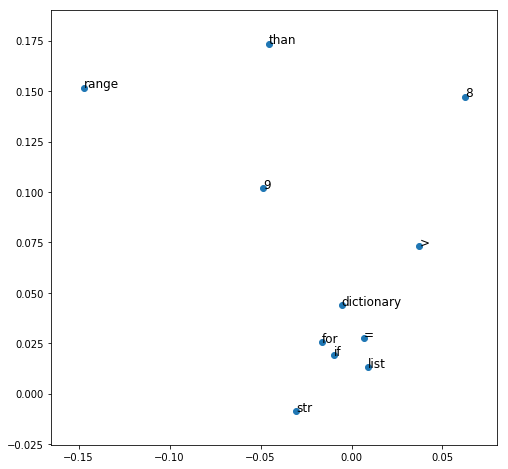

In [102]:
embedding_scatter_plot(u_pca_embedding_matrix, u_word_list, test_list)

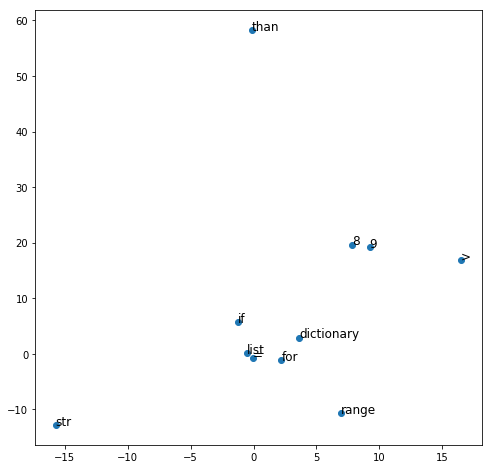

In [103]:
embedding_scatter_plot(u_tsne_embedding_matrix, u_word_list, test_list)

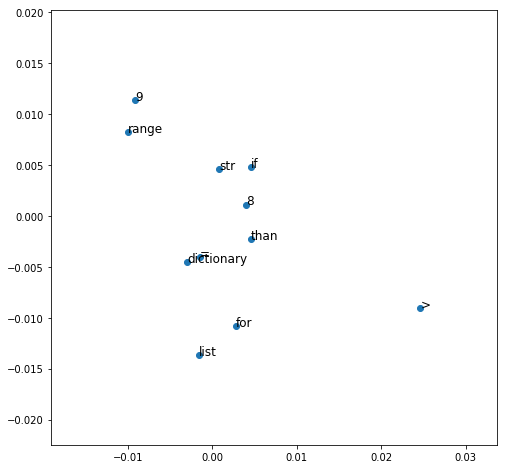

In [104]:
embedding_scatter_plot(s_pca_embedding_matrix, s_word_list, test_list)

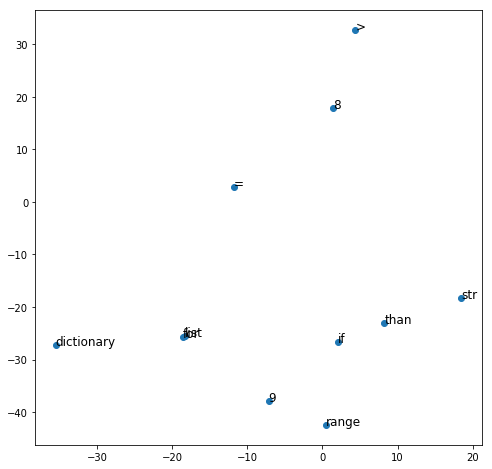

In [105]:
embedding_scatter_plot(s_tsne_embedding_matrix, s_word_list, test_list)